In [14]:
import NewCore
import os
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane')
import Functions
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import binary_fill_holes as bfh

from ipywidgets import interact, fixed
from IPython.display import display

def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

import skimage
from skimage import filters

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()

In [15]:
paths =['/MachineLearning/python tutorials/tutorial3/',
        '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample3/',
        '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample6/',
         '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample4/',
         '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample5/S5_Pre_rigid.nrrd',
         '/Users/fair00542/Desktop/TestImages/ScanB/ScanB',
         '/Users/fair00542/Desktop/TestImages/ScanF/ScanF']

path = paths[1]
print( "Reading Dicom directory:", path)

# if Dicom
# reader = sitk.ImageSeriesReader()
# dicom_names = reader.GetGDCMSeriesFileNames(path)
# reader.SetFileNames(dicom_names)
# img = reader.Execute()
# img = sitk.ReadImage(dicom_names)
# msk = sitk.ReadImage(path + '/opt_foramen_cut.nii.gz')

img = sitk.ReadImage(path + '/Post/New_MP.nii.gz')
img_array = sitk.GetArrayFromImage(img)
array = np.swapaxes(img_array,0,2)
ConstPixelSpacing = img.GetSpacing()

ML_array = array
# ideal midplane
Ideal_ML = np.multiply(ML_array == 1,ML_array)
# Deformed midplane
Deformed_ML = np.multiply(ML_array == 2,ML_array)

#Import ideal midplane parameters
# paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_preop.npy')
pa = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/tutorial3.npy')

# Post op parameters
# Post-op midplane parameters
paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_postop.npy')

# print('CT image')
# display_image(img, x=200, y=200, z=100, window=120, level=40)

# print('Brain mask')
# display_image(msk, x=200, y=200, z=100)

Reading Dicom directory: /Volumes/FAIR/Sinead/DC-Project-Images/original/Sample3/


In [3]:
paras[15]

IndexError: index 15 is out of bounds for axis 0 with size 11

In [16]:
# # Pre_op midplane parameters
# # paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_preop.npy')
# file, a, b, c, d = paras[15]
# a, b, c, d = a.astype(float),b.astype(float),c.astype(float),d.astype(float)
# v = np.array((a,b,c))
# v = v.astype(float)
# print(file, a, b, c, d, path)

# Post-op midplane parameters
file,a,b,c,d =paras[1]
a,b,c,d = a.astype(float),b.astype(float),c.astype(float),d.astype(float)
file

# midplane normal vector regulate the direction
if a<0:
    a,b,c,d = a*-1,b*-1,c*-1,d*-1
n = np.array((a,b,c))

#define rotation axis in plane, in z direction correlates to skew angle
from sympy import *
import sympy
x = sympy.symbols('x')
x1 = solve(a*x + b*100 + c*0 - d, x)
x2 = solve(a*x + b*100 + c*100 - d, x)
k = np.array((x1[0]-x2[0],0,-100)).astype(float)
# k = k/np.sqrt((k[0]**2 + k[1]**2 + k[2]**2))
vk_unit = Functions.unit_vector(k)
vk_unit

## Define rotation axis in y direction, correlating to the orientation angle
x = sympy.symbols('x')
x3 = solve(a*x + b*0.0 + c*100.0- d, x)
x4 = solve(a*x + b*100.0 + c*100.0 - d, x)

k2 = np.array((x3[0]-x4[0],-100.0,0.0)).astype(float)
vk2_unit = Functions.unit_vector(k2)
# the new_vk corresponds to the reshaped version of array, as displayed in ITK
# new_vk = Functions.unit_vector(vk_unit*ConstPixelSpacing)
vk2_unit

#the orientation angle
yaxis = np.array((0,1,0))
angle_ori = Functions.ang(vk2_unit,yaxis)
zaxis = np.array((0,0,1))
# angle_skew = Functions.ang(new_vk,zaxis)
angle_skew = Functions.ang(vk_unit,zaxis)

# Convert to degrees
# The skew angle 
A_S = 180.0 - angle_skew/np.pi*180.0
# The orientation angle
A_O = 180.0 - angle_ori/np.pi*180.0

if vk2_unit[0]*vk2_unit[1] < 0.0:
    A_O = -1*A_O
    
if vk_unit[0]*vk_unit[2] < 0.0:
    A_S = -1*A_S
    
# Calculate the x-coordinate of the miplane, should be a uniform value

# Constant mode rotation, points outside the boundaries of the input 
# are filled with constant 0.0. If points

from scipy.ndimage.interpolation import rotate
r_IML = rotate(Ideal_ML,A_O,mode='constant',axes=(0,1))
r2_IML = rotate(r_IML,A_S,mode='constant',axes=(0,2))

r_DML = rotate(Deformed_ML,A_O,mode='constant',axes=(0,1))
r2_DML = rotate(r_DML,A_S,mode='constant',axes=(0,2))

In [17]:
# Somehow the rotated mask is not binary, needs clarification.
Binary_Mask = np.zeros(r2_DML.shape)
Binary_Mask[np.abs(r2_DML)>0.99999999999999994435]=1

# Adjust the threshold level until the number of active pixels become approximately the same
np.sum(np.nonzero(Deformed_ML)),np.sum(np.nonzero(Binary_Mask)),

(65450559, 108648141)

In [18]:
x1,y1,z1 = np.nonzero(Binary_Mask)
# x1,y1,z1 = x*ConstPixelSpacing[0],y*ConstPixelSpacing[1],z*ConstPixelSpacing[2]
y1 = y1.astype(int)
z1 = z1.astype(int)

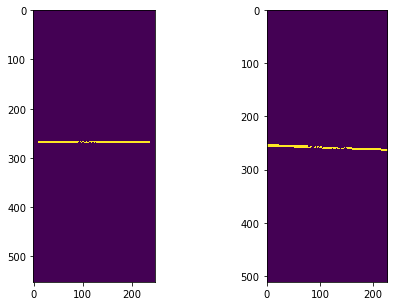

In [19]:
i = 100

plt.figure(figsize=(16,5))
plt.subplot(141)

plt.imshow(r2_IML[:,i,:])
plt.subplot(142)
plt.imshow(Ideal_ML[:,i,:])
plt.show()

In [20]:
# Check the spread range of x1 value should be very small
# Calculate the reference_x coordinates
xr = np.nonzero(r2_IML)[0]
counts = np.bincount(xr)
reference_x = np.argmax(counts)

NewCore.distribution(xr,10)

# # Get the number of points
# num_pts = len(xr.flatten())

# # Extract the minimum and maximum intensity values and calculate the number of bins for the histogram
# lim_low = np.min(xr)
# lim_high = np.max(xr)
# # num_bins = (lim_high - lim_low + 1)
# num_bins = 10

# plt.figure(figsize=(10, 4), dpi=100)
# plt.hist(xr, bins=num_bins, normed=True, range=(lim_low, lim_high), color='lightgray');
# plt.xlim([lim_low,lim_high]); # we limit the x-axis to the range of interest
# plt.show()

# print('Number of points ' + str(num_pts))

NameError: name 'plt' is not defined

In [29]:
counts = np.bincount(np.nonzero(r2_IML)[0])
reference_x = np.argmax(counts)

dev = x1 - reference_x
dev = dev.astype(float)

# Deviation to the right is positive!

if np.sum(dev>0) < np.sum(dev<0):
    dev = dev * -1
    print("Midplane shift to the left hemisphere")

# Normalization 
# Nor_dev = (dev/dev.max()).astype(float)
# Use the pre-op maximum MLS as a reference
Nor_dev = (dev/(16.3281/ConstPixelSpacing[0])).astype(float)

# shift to opposite direction is likely to be noise when drawing manual midline
# Nor_dis[-0.2<Nor_dis and Nor_dis<0.0] = 0.001
# Check the negative shift is inaccuracy of manual delineation

if Nor_dev.min() < 0.0 and Nor_dev.min() > -0.33:
    print('inaccuracy near the falx attachment corrected')
#     Rewrite the falx region to correct the bias
    Nor_dev[Nor_dev<0.0] = 0.001
elif Nor_dev.min() < -0.33:
    print('double check the manual MP and the ideal MP')

Brain_mask = np.zeros((int(z1.max()+1.0),int(y1.max()+1.0)))
for i in range(len(z1)):
    Brain_mask[z1[i],y1[i]]= Nor_dev[i]

ConstPixelSpacing = img.GetSpacing()


# Deviation volume 
Dev_volume = np.sum(np.absolute(Nor_dev))*dev.max()*ConstPixelSpacing[0]*ConstPixelSpacing[1]*ConstPixelSpacing[2]
print (Dev_volume)

Midplane shift to the left hemisphere
inaccuracy near the falx attachment corrected
96728.437393


In [31]:
Nor_dev.max()

0.69378096655458998

In [22]:
np.where(Nor_dev==Nor_dev.min()),Nor_dev.max()
x1[159321],y1[159321],z1[159321],Nor_dev.min()


(273, 415, 135, -0.0)

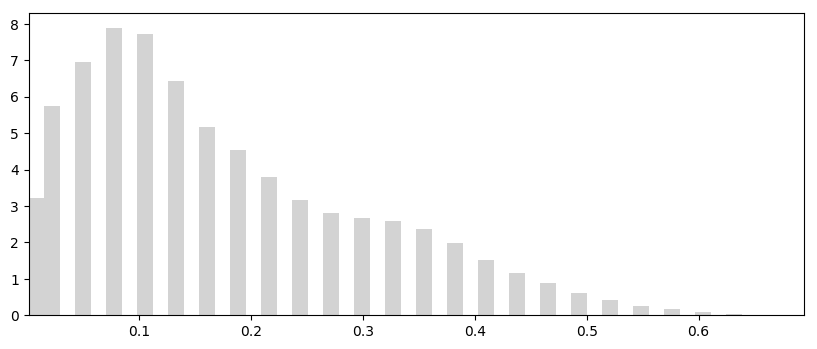

Number of points 151733


In [32]:
# Get the number of points
X = Nor_dev[Nor_dev != 0].flatten().reshape(-1,1)
num_pts = len(X.flatten())

# Extract the minimum and maximum intensity values and calculate the number of bins for the histogram
lim_low = np.min(X)
lim_high = np.max(X)
# num_bins = (lim_high - lim_low + 1)
num_bins = 50

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(X, bins=num_bins, normed=True, range=(lim_low, lim_high), color='lightgray');
plt.xlim([lim_low,lim_high]); # we limit the x-axis to the range of interest
plt.show()

print('Number of points ' + str(num_pts))

In [33]:
import scipy.io
mm = np.array([y1,z1,Nor_dev])
ConstPixelSpacing = np.array([ConstPixelSpacing[0],ConstPixelSpacing[1],ConstPixelSpacing[2],dev.max()])
scipy.io.savemat('relative_SP3_post.mat',{'mm':mm,'ConstPixelSpacing':ConstPixelSpacing})